## Package Installation and device checking

In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from typing import List
device = "cuda" if torch.cuda.is_available() else "cpu"

## Interleaving Tokenization Method (Garg et al., 2022)

In training GPT-2, we consider an alternative tokenization method called **Interleave**, where the features `x` and `y` are interleaved into separate tokens.

### Tokenization Process:
E(P) =
\begin{pmatrix}
x_1 & 0 & x_2 & 0 & \cdots & x_N & 0 & x_{query} \\
0 & y_1 & 0 & y_2 & \cdots & 0 & y_N & 0
\end{pmatrix} \in \mathbb{R}^{(d+1)\times(2N+1)}

### Causal Masking:
To ensure that the i-th column only depends on the columns ≤ i, **causal masking** is used. This allows the formulation of a next-token prediction averaged across all `N` pairs of examples, with the following loss function:

$$
\hat{L}(\theta) = \frac{1}{2B} \sum_{\tau=1}^{B} \left( \frac{1}{N} \sum_{i=1}^{N} \left( f^{Mask}(E_{\tau}; \theta)_{d+1,2i+1} - y_{\tau,i+1} \right)^2 \right)
$$

### Reference:
This formulation was originally used in the work by **Garg et al. (2022)**.


In [2]:
# class LoRALayer:
#     def __init__(self, r: int, lora_alpha: int, lora_dropout: float):
#         self.r = r
#         self.lora_alpha = lora_alpha
#         self.lora_dropout = nn.Dropout(p=lora_dropout) if lora_dropout > 0. else lambda x: x

# # class LoRAcAttnWrapper(nn.Module):
# #     def __init__(self, lora_adapter_q, lora_adapter_k, original_v):
# #         super().__init__()
# #         self.lora_adapter_q = lora_adapter_q
# #         self.lora_adapter_k = lora_adapter_k
# #         self.original_v = original_v

# #     def forward(self, x):
# #         q = self.lora_adapter_q(x)
# #         k = self.lora_adapter_k(x)
# #         v = self.original_v(x)
# #         return torch.cat([q, k, v], dim=-1)

# class LoRAcAttnWrapper(nn.Module):
#     def __init__(self, lora_adapter_q, lora_adapter_k, original_v, bias_q, bias_k, bias_v):
#         super().__init__()
#         self.lora_adapter_q = lora_adapter_q
#         self.lora_adapter_k = lora_adapter_k
#         self.original_v = original_v

#         # Bias terms
#         self.bias_q = nn.Parameter(bias_q)
#         self.bias_k = nn.Parameter(bias_k)
#         self.bias_v = nn.Parameter(bias_v)

#     def forward(self, x):
#         q = self.lora_adapter_q(x) + self.bias_q
#         k = self.lora_adapter_k(x) + self.bias_k
#         v = self.original_v(x) + self.bias_v
#         return torch.cat([q, k, v], dim=-1)


# class LoRAAdapter(nn.Module, LoRALayer):
#     def __init__(
#         self,
#         existing_layer: nn.Module,
#         in_features,
#         out_features,
#         r: int = 0,
#         lora_alpha: int = 1,
#         lora_dropout: float = 0.,
#     ):
#         nn.Module.__init__(self)
#         LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
#         self.existing_layer = existing_layer

#         existing_dtype = next(existing_layer.parameters()).dtype
#         if r > 0:
#             self.lora_A = nn.Parameter(torch.zeros((in_features, r), dtype=existing_dtype))
#             self.lora_B = nn.Parameter(torch.zeros((r, out_features), dtype=existing_dtype))
#             self.scaling = self.lora_alpha / (self.r ** 0.5)
#             self.reset_parameters()

#     def reset_parameters(self):
#         if hasattr(self, 'lora_A'):
#             nn.init.normal_(self.lora_A, mean=0, std=0.02)
#         if hasattr(self, 'lora_B'):
#             nn.init.zeros_(self.lora_B)
#             # nn.init.xavier_uniform_(self.lora_B)


#     def forward(self, x: torch.Tensor):
#         if self.r > 0:
#             lora_output = self.lora_dropout(x) @ self.lora_A
#             # Fuse second matrix multiply and scaling
#             lora_output = (lora_output @ self.lora_B) * self.scaling
#             # Single addition with original output
#             return self.existing_layer(x) + lora_output
#         else:
#             return self.existing_layer(x)


# def replace_c_attn_with_lora(model: nn.Module, r: int, lora_alpha: int, lora_dropout: float):
#     for name, module in model.named_modules():
#         if "c_attn" in name:
#             # Extract original c_attn module
#             original_layer = module
#             in_features, out_features = original_layer.weight.shape
#             hidden_dim = out_features // 3  # Split into Q, K, V

#             original_bias = original_layer.bias
#             bias_q = original_bias[:hidden_dim].detach().clone()
#             bias_k = original_bias[hidden_dim:2 * hidden_dim].detach().clone()
#             bias_v = original_bias[2 * hidden_dim:].detach().clone()

#             # Extract pre-trained weights for Q, K, V
#             weight_q = original_layer.weight[:, :hidden_dim].detach().clone()
#             weight_k = original_layer.weight[:, hidden_dim:2 * hidden_dim].detach().clone()
#             weight_v = original_layer.weight[:, 2 * hidden_dim:].detach().clone()

#             # LoRA for Q and K
#             lora_adapter_q = LoRAAdapter(
#                 existing_layer=nn.Linear(in_features, hidden_dim, bias=False),
#                 in_features=in_features,
#                 out_features=hidden_dim,
#                 r=r,
#                 lora_alpha=lora_alpha,
#                 lora_dropout=lora_dropout
#             )
#             lora_adapter_q.existing_layer.weight = nn.Parameter(weight_q)

#             lora_adapter_k = LoRAAdapter(
#                 existing_layer=nn.Linear(in_features, hidden_dim, bias=False),
#                 in_features=in_features,
#                 out_features=hidden_dim,
#                 r=r,
#                 lora_alpha=lora_alpha,
#                 lora_dropout=lora_dropout
#             )
#             lora_adapter_k.existing_layer.weight = nn.Parameter(weight_k)

#             # Keep V as is
#             original_v = nn.Linear(in_features, hidden_dim, bias=False)
#             original_v.weight = nn.Parameter(weight_v)

#             # Combine Q, K, and V with LoRA modifications
#             # lora_c_attn_module = LoRAcAttnWrapper(lora_adapter_q, lora_adapter_k, original_v)
#             lora_c_attn_module = LoRAcAttnWrapper(lora_adapter_q, lora_adapter_k, original_v, bias_q, bias_k, bias_v)


#             # Replace c_attn module
#             parts = name.split(".")
#             parent = model
#             for part in parts[:-1]:
#                 parent = getattr(parent, part)
#             # print(parent)
#             # print(parts[-1])
#             # print(lora_c_attn)
#             # setattr(parent, parts[-1], lora_c_attn)
#             setattr(parent, parts[-1], lora_c_attn_module)


# # Mark only LoRA parameters as trainable
# def mark_only_lora_as_trainable(model: nn.Module):
#     for name, param in model.named_parameters():
#         if "lora_A" in name or "lora_B" in name or "ln_" in name or "ln_f" in name:
#             param.requires_grad = True
#         else:
#             param.requires_grad = False

In [3]:
class LoRALayer:
    def __init__(self, r: int, lora_alpha: int, lora_dropout: float):
        self.r = r
        self.lora_alpha = lora_alpha
        self.lora_dropout = nn.Dropout(p=lora_dropout) if lora_dropout > 0. else lambda x: x

class LoRAAdapter(nn.Module, LoRALayer):
    def __init__(
        self,
        existing_layer: nn.Module,
        in_features,
        out_features,
        r: int = 0,
        lora_alpha: int = 1,
        lora_dropout: float = 0.,
    ):
        nn.Module.__init__(self)
        LoRALayer.__init__(self, r=r, lora_alpha=lora_alpha, lora_dropout=lora_dropout)
        self.existing_layer = existing_layer

        # Always create LoRA parameters if r > 0
        if r > 0:
            # self.lora_A = nn.Parameter(torch.zeros(in_features, r))  # [256, r]
            # self.lora_B = nn.Parameter(torch.zeros(r, out_features))  # [r, 768]
            self.register_parameter(
                'lora_A',
                nn.Parameter(torch.zeros(in_features, r))
            )
            self.register_parameter(
                'lora_B',
                nn.Parameter(torch.zeros(r, out_features))
            )
            self.weight = self.lora_A @ self.lora_B
            self.scaling = self.lora_alpha / (self.r ** 0.5)
            self.reset_parameters()


    def reset_parameters(self):
        if hasattr(self, 'lora_A'):
            nn.init.normal_(self.lora_A, mean=0, std=0.02)
        if hasattr(self, 'lora_B'):
            nn.init.xavier_uniform_(self.lora_B)

    def forward(self, x: torch.Tensor):
        if self.r > 0:
            # Compute LoRA path
            lora_output = (self.lora_dropout(x) @ self.lora_A @ self.lora_B) * self.scaling
            # Use original layer
            return self.existing_layer(x) + lora_output
        else:
            return self.existing_layer(x)


    # def forward(self, x: torch.Tensor):
    #     if self.r > 0:
    #         # Apply LoRA to full input
    #         print(self.lora_A.shape) # torch.Size([256, 8])
    #         lora_output = self.lora_dropout(x) @ self.lora_A
    #         print(self.lora_B.shape) # torch.Size([8, 768])

    #         lora_output = (lora_output @ self.lora_B) * self.scaling
    #         print(x.shape) # torch.Size([128, 128, 256])
    #         print(self.existing_layer.weight.shape) # torch.Size([256, 768])
    #         return self.existing_layer(x) + lora_output
    #     else:
    #         return self.existing_layer(x)

def replace_c_attn_with_lora(model: nn.Module, r: int, lora_alpha: int, lora_dropout: float):
    for name, module in model.named_modules():
        if "c_attn" in name:
            # Get original layer dimensions
            original_layer = module
            # GPT2's Conv1D layer has weight shape [out_features, in_features]
            in_features = original_layer.weight.size(0)  # Should be 256
            out_features = original_layer.weight.size(1)  # Should be 768 (3*256)
            # Create LoRA adapter with correct dimensions
            lora_adapter = LoRAAdapter(
                existing_layer=original_layer,
                in_features=in_features,
                out_features=out_features,
                r=r,  # Make sure this is passed as non-zero
                lora_alpha=lora_alpha,
                lora_dropout=lora_dropout
            )

            # Replace original layer
            parts = name.split(".")
            parent = model
            for part in parts[:-1]:
                parent = getattr(parent, part)
            setattr(parent, parts[-1], lora_adapter)

def mark_only_lora_as_trainable(model: nn.Module):
    for name, param in model.named_parameters():
        if "lora_A" in name or "lora_B" in name:
            # print(f"Setting {name} as trainable")
            param.requires_grad = True
        else:
            param.requires_grad = False

In [4]:
from transformers import GPT2Model, GPT2Config
# GPT2 Model with LoRA
class MyGPT2Model(nn.Module):
    def __init__(self, input_dim, output_dim, embed_dim=256, num_layers=8, num_heads=4):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, embed_dim)
        self.output_layer = nn.Linear(embed_dim, output_dim)
        config = GPT2Config(
            n_embd=embed_dim,
            n_layer=num_layers,
            n_head=num_heads
        )
        self.gpt2 = GPT2Model._from_config(config)

    def insert_lora(self):
        replace_c_attn_with_lora(self.gpt2, r=8, lora_alpha=8, lora_dropout=0.1)
        mark_only_lora_as_trainable(self.gpt2)

    def forward(self, x):
        x = self.input_layer(x)
        x = self.gpt2(inputs_embeds=x).last_hidden_state
        x = self.output_layer(x)
        return x

## Dataset setup

In [5]:

class MyDataset(torch.utils.data.Dataset):
    """ y = W * x, where w ~ N(0,I) and x ~ U(-1,1) """
    def __init__(self, x_dim, y_dim, len, L=None):
        self.x_dim = x_dim
        self.y_dim = y_dim
        self.len = len
        self.L = 4 * max(x_dim, y_dim) if L is None else L

    def __len__(self):
        return self.len

    def __getitem__(self, _):
        d = max(self.x_dim, self.y_dim)
        x = torch.rand(self.L, self.x_dim) * 2 - 1 # (num_samples, x_dim)
        w = torch.randn(self.x_dim, self.y_dim) / (d ** 0.5)
        y = x @ w
        return x, y, w

## General training setups

In [6]:
x_dim, y_dim, embed_dim = 16, 1, 256
num_layers, num_heads = 6, 2
bsize, num_steps = 64, 8000
lr, weight_decay = 1e-4, 1e-8
dataset = MyDataset(x_dim, y_dim, bsize * num_steps, L=64)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize)

## Training GPT2

Here we adopt the interleaving method from Garg et al. 2022. Here is the demonstration:

In [11]:
model = MyGPT2Model(x_dim+y_dim, x_dim+y_dim).train().to(device)

# for name, param in model.named_parameters():
#     print(f"{name}: {param.shape}")
# total_params = sum(p.numel() for p in model.parameters())
# trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# print(f"Total Parameters: {total_params}")
# print(f"Trainable Parameters: {trainable_params}")

In [12]:
import os
from datetime import datetime

# Create checkpoint directory
checkpoint_dir = "1checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(model, optimizer, iteration, loss, batch_losses, is_best=False):
    checkpoint = {
        'iteration': iteration,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'batch_losses': batch_losses
    }

    # Save regular checkpoint
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = os.path.join(checkpoint_dir, f'checkpoint_iter_{iteration}_{timestamp}.pt')
    torch.save(checkpoint, filename)

    # Save best model if this is best loss
    if is_best:
        best_filename = os.path.join(checkpoint_dir, 'best_model.pt')
        torch.save(checkpoint, best_filename)

def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iteration = checkpoint['iteration']
    batch_losses = checkpoint['batch_losses']
    return start_iteration, batch_losses

In [9]:
# Load checkpoint if exists
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
start_iteration = 0
if os.path.exists(os.path.join(checkpoint_dir, 'best_model.pt')):
    start_iteration, batch_losses = load_checkpoint(
        model,
        optimizer,
        os.path.join(checkpoint_dir, 'best_model.pt')
    )
else:
    batch_losses = []

epoch_losses = []
best_loss = float('inf')
checkpoint_freq = 2500  # Save every 500 iterations

In [15]:
pbar = tqdm(dataloader)
c = start_iteration
for (x, y, w) in pbar:
    c+=1
    x, y = x.to(device), y.to(device)
    L = x.size(1)

    x_big = torch.cat([x, torch.zeros(bsize, L, y_dim, device=device)], dim=2)
    y_big = torch.cat([torch.zeros(bsize, L, x_dim, device=device), y], dim=2)
    # y_big[:,-1,-y_dim:] = 0.

    z = torch.cat([x_big, y_big], dim=2).view(bsize,2*L,x_dim+y_dim)

    # y_big = torch.cat([y, torch.zeros(bsize, y.size(1), x_dim - y_dim, device=device)], dim=-1)
    # z = torch.stack([x, y_big], dim=2).view(bsize, 2 * x.size(1), x_dim).to(device)

    # z: (bsize, 2L, x_dim+y_dim)
    # out: (bsize, 2L, x_dim+y_dim)
    out = model(z)

    y_pred = out[:, 0::2, -y_dim:]
    # print(f"out {out.shape}, y_pred {y_pred.shape}, y {y.shape}")

    loss = torch.nn.functional.mse_loss(y, y_pred)
    batch_losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Save checkpoint periodically
    if c % checkpoint_freq == 0:
        save_checkpoint(model, optimizer, c, loss.item(), batch_losses)

    if loss.item() < best_loss:
        best_loss = loss.item()
        save_checkpoint(model, optimizer, c, loss.item(), batch_losses, is_best=True)

    # if loss.item() < 1e-1:
    #     save_checkpoint(model, optimizer, c, loss.item(), batch_losses)
    #     print("At the elbow")
    #     break
    pbar.set_description(f"loss: {loss.item():.3e}")

# Save final checkpoint
save_checkpoint(model, optimizer, c, loss.item(), batch_losses)

avg_epoch_loss = sum(batch_losses) / len(batch_losses)
epoch_losses.append(avg_epoch_loss)
print(f"average loss: {avg_epoch_loss:.4f}")


loss: 5.239e-01: 100%|██████████| 8000/8000 [33:37<00:00,  3.96it/s]

average loss: 0.5277


In [148]:
def visualize_lora_weights(model, layer_name="gpt2.h.0.attn.c_attn"):
    """
    Visualize original weights, LoRA weights, and effective weights for a given layer
    """
    # Get the layer
    layer = None
    for name, module in model.named_modules():
        if name == layer_name:
            layer = module
            break

    if layer is None:
        print(f"Layer {layer_name} not found")
        return

    # Original weights (W0)
    W0_q = layer.lora_adapter_q.existing_layer.weight.detach().cpu()
    W0_k = layer.lora_adapter_k.existing_layer.weight.detach().cpu()

    # LoRA weights (BA)
    lora_A_q = layer.lora_adapter_q.lora_A.detach().cpu()
    lora_B_q = layer.lora_adapter_q.lora_B.detach().cpu()
    lora_A_k = layer.lora_adapter_k.lora_A.detach().cpu()
    lora_B_k = layer.lora_adapter_k.lora_B.detach().cpu()

    # Calculate effective LoRA weights
    scaling_q = layer.lora_adapter_q.scaling
    scaling_k = layer.lora_adapter_k.scaling

    W_lora_q = (lora_A_q @ lora_B_q) * scaling_q
    W_lora_k = (lora_A_k @ lora_B_k) * scaling_k

    # Total effective weights
    W_eff_q = W0_q + W_lora_q
    W_eff_k = W0_k + W_lora_k

    # Plot the weights
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Weight Analysis for Query and Key Matrices')

    # Function to plot with consistent colormap
    def plot_weight_matrix(ax, matrix, title):
        vmax = np.abs(matrix).max()
        im = ax.imshow(matrix, cmap='RdBu_r', norm=plt.Normalize(-vmax, vmax))
        ax.set_title(title)
        plt.colorbar(im, ax=ax)
        return im

    # Query weights
    plot_weight_matrix(axes[0,0], W0_q, 'Original W0 (Query)')
    plot_weight_matrix(axes[0,1], W_lora_q, 'LoRA Update (Query)')
    plot_weight_matrix(axes[0,2], W_eff_q, 'Effective W (Query)')

    # Key weights
    plot_weight_matrix(axes[1,0], W0_k, 'Original W0 (Key)')
    plot_weight_matrix(axes[1,1], W_lora_k, 'LoRA Update (Key)')
    plot_weight_matrix(axes[1,2], W_eff_k, 'Effective W (Key)')

    plt.tight_layout()
    plt.show()

In [162]:
def visualize_c_attn_weights(model):
    # Get the first attention layer
    c_attention = model.gpt2.h[0].attn.c_attn

    # Get original weights
    W_original = c_attention.existing_layer.weight.detach().cpu().numpy()

    # Compute LoRA contribution (delta W)
    lora_A = c_attention.lora_A.detach().cpu().numpy()
    lora_B = c_attention.lora_B.detach().cpu().numpy()
    delta_W = (lora_A @ lora_B) * c_attention.scaling

    # Split weights for Q, K, V
    hidden_size = W_original.shape[1] // 3

    # Original weights split
    W_q_orig = W_original[:, :hidden_size]
    W_k_orig = W_original[:, hidden_size:2*hidden_size]

    # LoRA delta weights split
    W_q_delta = delta_W[:, :hidden_size]
    W_k_delta = delta_W[:, hidden_size:2*hidden_size]

    # Plot setup
    fig, axes = plt.subplots(2, 2, figsize=(8, 10))
    fig.suptitle('Original Weights vs LoRA Delta Weights')

    def plot_weight_matrix(ax, matrix, title):
        vmax = np.abs(matrix).max()
        im = ax.imshow(matrix, cmap='RdBu_r', norm=plt.Normalize(-vmax, vmax))
        ax.set_title(f"{title}\nmax: {vmax:.2e}")
        plt.colorbar(im, ax=ax)
        return im

    # Original weights
    plot_weight_matrix(axes[0,0], W_q_orig, 'Original Query Weights')
    plot_weight_matrix(axes[0,1], W_k_orig, 'Original Key Weights')

    # LoRA delta weights
    plot_weight_matrix(axes[1,0], W_q_delta, 'LoRA Delta Query Weights')
    plot_weight_matrix(axes[1,1], W_k_delta, 'LoRA Delta Key Weights')

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nWeight Statistics:")
    print(f"Original Weights - Mean: {W_original.mean():.2e}, Std: {W_original.std():.2e}")
    print(f"LoRA Delta - Mean: {delta_W.mean():.2e}, Std: {delta_W.std():.2e}")
    print(f"Ratio of magnitudes (LoRA/Original): {np.abs(delta_W).mean()/np.abs(W_original).mean():.2e}")

In [27]:
x_dim, y_dim, embed_dim = 16, 1, 256
num_layers, num_heads = 6, 2
bsize, num_steps = 64, 10000
lr, weight_decay = 1e-4, 1e-8
dataset = MyDataset(x_dim, y_dim, bsize * num_steps, L=64)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=bsize)
model = MyGPT2Model(x_dim+y_dim, x_dim+y_dim).train().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
start_iteration, batch_losses = load_checkpoint(
    model,
    optimizer,
    # os.path.join(checkpoint_dir, 'best_model.pt')
    os.path.join(checkpoint_dir, 'checkpoint_iter_8000_20241215_210313.pt')
)
model.insert_lora()
model = model.train().to(device)



C:\Users\YYX\AppData\Local\Temp\ipykernel_37980\3731728166.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [17]:
def visualize_first_4_layers_compact(model):
    num_layers = 4  # First 4 layers only

    # Global max for consistent scaling
    max_val = 0
    for layer_idx in range(num_layers):
        c_attention = model.gpt2.h[layer_idx].attn.c_attn
        W = c_attention.existing_layer.weight.detach().cpu().numpy()
        max_val = max(max_val, np.abs(W).max())

    # Set up the figure: 1 row, 8 columns
    fig, axes = plt.subplots(
        nrows=1, ncols=num_layers * 2, figsize=(2 * num_layers * 2, 2.5),
        gridspec_kw={'wspace': 0.05, 'hspace': 0}
    )

    def plot_heatmap(ax, matrix, title, vmin, vmax):
        im = ax.imshow(matrix, cmap='RdBu_r', vmin=vmin, vmax=vmax)
        ax.set_xticks([])  # Remove ticks
        ax.set_yticks([])
        ax.set_title(title, fontsize=8, pad=10)
        return im

    # Plot W_q and W_k for the first 4 layers
    for layer_idx in range(num_layers):
        c_attention = model.gpt2.h[layer_idx].attn.c_attn
        W = c_attention.existing_layer.weight.detach().cpu().numpy()

        hidden_size = W.shape[1] // 3
        W_q = W[:, :hidden_size]
        W_k = W[:, hidden_size:2*hidden_size]

        # Left column: W_q | Right column: W_k
        im = plot_heatmap(axes[layer_idx * 2], W_q, f"L{layer_idx} W_q", -max_val, max_val)
        plot_heatmap(axes[layer_idx * 2 + 1], W_k, f"L{layer_idx} W_k", -max_val, max_val)

    # Colorbar on the LEFT
    cbar_ax = fig.add_axes([0.05, 0.2, 0.02, 0.6])  # Adjust position to the left
    cbar = plt.colorbar(im, cax=cbar_ax)  # Single colorbar creation
    cbar.set_label("Weight Value", fontsize=8)  # Smaller font for label
    cbar.ax.tick_params(labelsize=7)  # Smaller font for tick labels


    # Finalize layout
    plt.tight_layout(pad=0.5, rect=[0.1, 0, 1, 1])  # Adjust for colorbar space
    plt.show()


In [204]:

from matplotlib.colors import SymLogNorm

def visualize_first_4_layers_compact(model):
    num_layers = 4  # First 4 layers only

    # Global max for consistent scaling
    max_val = 0
    for layer_idx in range(num_layers):
        c_attention = model.gpt2.h[layer_idx].attn.c_attn
        W = c_attention.existing_layer.weight.detach().cpu().numpy()
        max_val = max(max_val, np.abs(W).max())

    # Set up the figure: 1 row, 8 columns
    fig, axes = plt.subplots(
        nrows=1, ncols=num_layers * 2, figsize=(2 * num_layers * 2, 2.5),
        gridspec_kw={'wspace': 0.05, 'hspace': 0}
    )

    def plot_heatmap(ax, matrix, title, vmax):
        # Use SymLogNorm to make small values more intense
        im = ax.imshow(matrix, cmap='RdBu_r', norm=SymLogNorm(linthresh=0.01, vmin=-vmax, vmax=vmax))
        ax.set_xticks([])  # Remove ticks
        ax.set_yticks([])
        ax.set_title(title, fontsize=8, pad=10)
        return im

    # Plot W_q and W_k for the first 4 layers
    for layer_idx in range(num_layers):
        c_attention = model.gpt2.h[layer_idx].attn.c_attn
        W = c_attention.existing_layer.weight.detach().cpu().numpy()

        hidden_size = W.shape[1] // 3
        W_q = W[:, :hidden_size]
        W_k = W[:, hidden_size:2*hidden_size]

        # Left column: W_q | Right column: W_k
        im = plot_heatmap(axes[layer_idx * 2], W_q, f"L{layer_idx} W_q", max_val)
        plot_heatmap(axes[layer_idx * 2 + 1], W_k, f"L{layer_idx} W_k", max_val)

    # Colorbar on the LEFT
    cbar_ax = fig.add_axes([0.05, 0.2, 0.02, 0.6])  # Adjust position to the left
    cbar = plt.colorbar(im, cax=cbar_ax)  # Single colorbar creation
    cbar.set_label("Weight Value", fontsize=8)  # Smaller font for label
    cbar.ax.tick_params(labelsize=7)  # Smaller font for tick labels

    # Finalize layout
    plt.tight_layout(pad=0.5, rect=[0.1, 0, 1, 1])  # Adjust for colorbar space
    plt.show()

C:\Users\YYX\AppData\Local\Temp\ipykernel_1440\1406441616.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.5, rect=[0.1, 0, 1, 1])  # Adjust for colorbar space


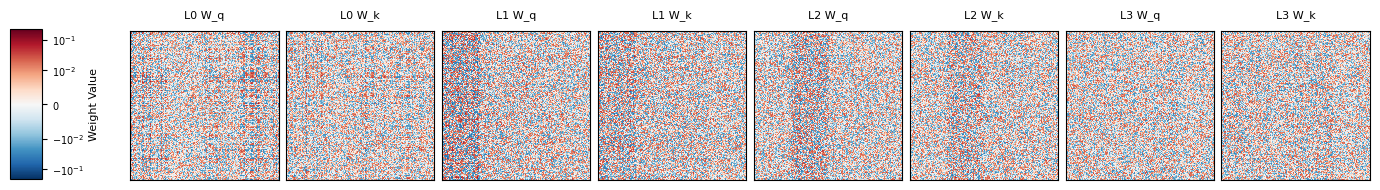

In [205]:
visualize_first_4_layers_compact(model)

In [28]:
pbar = tqdm(dataloader)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
c = start_iteration
for (x, y, w) in pbar:
    c+=1
    x, y = x.to(device), y.to(device)
    L = x.size(1)

    x_big = torch.cat([x, torch.zeros(bsize, L, y_dim, device=device)], dim=2)
    y_big = torch.cat([torch.zeros(bsize, L, x_dim, device=device), y], dim=2)
    # y_big[:,-1,-y_dim:] = 0.

    z = torch.cat([x_big, y_big], dim=2).view(bsize,2*L,x_dim+y_dim)

    # y_big = torch.cat([y, torch.zeros(bsize, y.size(1), x_dim - y_dim, device=device)], dim=-1)
    # z = torch.stack([x, y_big], dim=2).view(bsize, 2 * x.size(1), x_dim).to(device)

    # z: (bsize, 2L, x_dim+y_dim)
    # out: (bsize, 2L, x_dim+y_dim)
    out = model(z)

    y_pred = out[:, 0::2, -y_dim:]
    # print(f"out {out.shape}, y_pred {y_pred.shape}, y {y.shape}")

    loss = torch.nn.functional.mse_loss(y, y_pred)
    batch_losses.append(loss.item())

    loss.backward()
    # for name, param in model.named_parameters():
        # if param.requires_grad:
        #     print(f"{name} grad stats:")
        #     if param.grad is not None:
        #         print(f"  Mean: {param.grad.mean():.2e}")
        #         print(f"  Std: {param.grad.std():.2e}")
        #     else:
        #         print("  No gradients!")
    optimizer.step()
    optimizer.zero_grad()
    # if c % 5 == 0:
    #     visualize_c_attn_weights(model)
    # Save checkpoint periodically
    if c % 500 == 0:
        save_checkpoint(model, optimizer, c, loss.item(), batch_losses)

    if loss.item() < best_loss:
        best_loss = loss.item()
        save_checkpoint(model, optimizer, c, loss.item(), batch_losses, is_best=True)

    pbar.set_description(f"loss: {loss.item():.3e}")

# Save final checkpoint
save_checkpoint(model, optimizer, c, loss.item(), batch_losses)

avg_epoch_loss = sum(batch_losses) / len(batch_losses)
epoch_losses.append(avg_epoch_loss)
print(f"average loss: {avg_epoch_loss:.4f}")

loss: 3.194e-01: 100%|██████████| 10000/10000 [35:12<00:00,  4.73it/s]


average loss: 0.4457


In [114]:
for name, module in model.named_modules():
    print(f"Submodule: {name}")

Submodule: 
Submodule: input_layer
Submodule: output_layer
Submodule: gpt2
Submodule: gpt2.wte
Submodule: gpt2.wpe
Submodule: gpt2.drop
Submodule: gpt2.h
Submodule: gpt2.h.0
Submodule: gpt2.h.0.ln_1
Submodule: gpt2.h.0.attn
Submodule: gpt2.h.0.attn.c_attn
Submodule: gpt2.h.0.attn.c_attn.lora_dropout
Submodule: gpt2.h.0.attn.c_attn.existing_layer
Submodule: gpt2.h.0.attn.c_proj
Submodule: gpt2.h.0.attn.attn_dropout
Submodule: gpt2.h.0.attn.resid_dropout
Submodule: gpt2.h.0.ln_2
Submodule: gpt2.h.0.mlp
Submodule: gpt2.h.0.mlp.c_fc
Submodule: gpt2.h.0.mlp.c_proj
Submodule: gpt2.h.0.mlp.act
Submodule: gpt2.h.0.mlp.dropout
Submodule: gpt2.h.1
Submodule: gpt2.h.1.ln_1
Submodule: gpt2.h.1.attn
Submodule: gpt2.h.1.attn.c_attn
Submodule: gpt2.h.1.attn.c_attn.lora_dropout
Submodule: gpt2.h.1.attn.c_attn.existing_layer
Submodule: gpt2.h.1.attn.c_proj
Submodule: gpt2.h.1.attn.attn_dropout
Submodule: gpt2.h.1.attn.resid_dropout
Submodule: gpt2.h.1.ln_2
Submodule: gpt2.h.1.mlp
Submodule: gpt2.h.1.ml

In [14]:
out.shape

torch.Size([128, 128, 15])

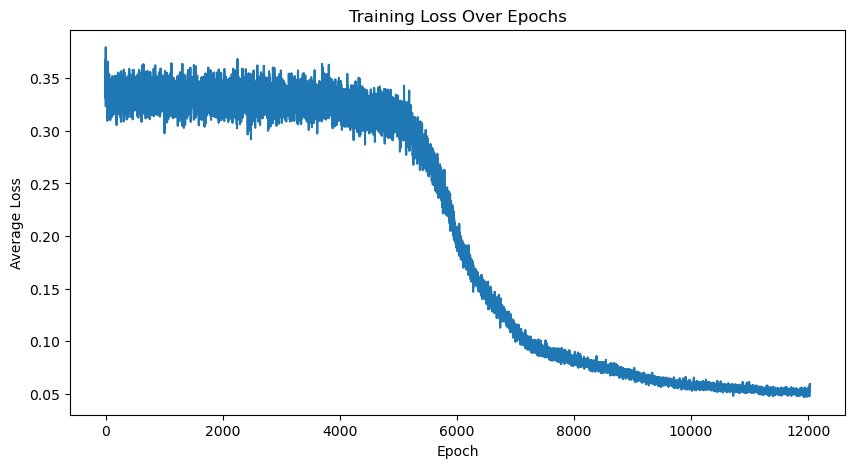

In [159]:
# plot loss curve
import numpy as np
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(batch_losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.show()

Now, having a trained model, we want to check its in-context learning behavior. By having two weight vectors $w_1, w_2$, we hope to shuffle the portions of the two weight vectors in the in context prompt.

In [160]:
def test_in_context_learning(model, x_dim, y_dim, num_runs=50, L=50):
    model.eval()
    device = next(model.parameters()).device
    mse_loss = nn.MSELoss(reduction='mean')

    proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1
    all_losses_w1 = []
    all_losses_w2 = []

    for _ in range(num_runs):
        losses_w1 = []
        losses_w2 = []

        for prop in proportions:
            num1 = int(L * prop)
            num2 = L - num1

            ds1 = MyDataset(x_dim, y_dim, 1, L=num1)
            ds2 = MyDataset(x_dim, y_dim, 1, L=num2)

            x1, y1, w1 = ds1[0]
            x2, y2, w2 = ds2[0]

            x1, y1, w1 = x1.to(device), y1.to(device), w1.to(device)
            x2, y2, w2 = x2.to(device), y2.to(device), w2.to(device)

            xs = torch.cat([x1, x2], dim=0)
            ys = torch.cat([y1, y2], dim=0)

            perm = torch.randperm(L, device=device)
            xs = xs[perm]
            ys = ys[perm]

            xs_big = torch.cat([xs, torch.zeros(L, y_dim, device=device)], dim=-1)
            ys_big = torch.cat([torch.zeros(L, x_dim, device=device), ys], dim=-1)

            # Interelaved
            zs_big = torch.cat([xs_big, ys_big], dim=-1).view(2*L, x_dim+y_dim)

            # both w1 and w2
            x_test = torch.rand(x_dim, device=device) * 2 - 1
            y_true_w1 = x_test @ w1
            y_true_w2 = x_test @ w2
            # y_guess = prop * y_true_w1 + (1 - prop) * y_true_w2
            y_guess = torch.zeros(y_dim, device=device)

            x_test_big = torch.cat([x_test, torch.zeros(y_dim, device=device)], dim=0).view(1, x_dim+y_dim)
            y_test_big = torch.cat([torch.zeros(1, x_dim, device=device), y_guess.view(1,y_dim)], dim=1)
            zs_test = torch.cat([x_test_big, y_test_big], dim=0)

            zs_all = torch.cat([zs_big, zs_test.view(2,x_dim+y_dim)], dim=0)

            # print(f"zs_all {zs_all.shape}")
            # print(zs_all)
            # break

            # Get model predictions
            with torch.no_grad():
                out = model(zs_all.view(1, 2*L + 2, x_dim+y_dim))

            y_pred = out[0, -2, -y_dim:]

            loss_w1 = mse_loss(y_pred, y_true_w1).item()
            loss_w2 = mse_loss(y_pred, y_true_w2).item()

            # print(loss_w1, loss_w2)
            # break

            losses_w1.append(loss_w1)
            losses_w2.append(loss_w2)

        # print(losses_w1)
        # print(losses_w2)
        # break
        all_losses_w1.append(losses_w1)
        all_losses_w2.append(losses_w2)

    # Calculate average losses across all runs
    # print(all_losses_w1)
    avg_losses_w1 = np.mean(all_losses_w1, axis=0)
    avg_losses_w2 = np.mean(all_losses_w2, axis=0)

    return avg_losses_w1, avg_losses_w2

# Run the test
avg_losses_w1, avg_losses_w2 = test_in_context_learning(model, x_dim, y_dim)

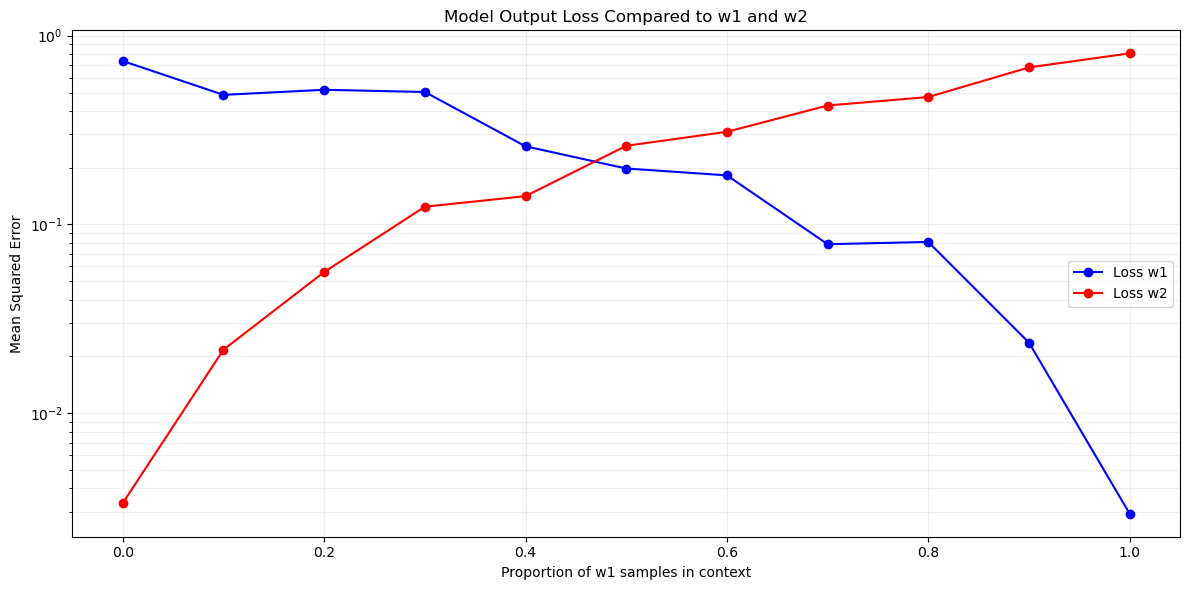

Average losses for w1: ['0.7339', '0.4858', '0.5169', '0.5031', '0.2594', '0.1979', '0.1820', '0.0786', '0.0808', '0.0237', '0.0029']
Average losses for w2: ['0.0033', '0.0217', '0.0560', '0.1242', '0.1413', '0.2610', '0.3097', '0.4267', '0.4731', '0.6789', '0.8060']


In [161]:
proportions = np.arange(0, 1.1, 0.1)  # 0 to 1.0 in steps of 0.1

plt.figure(figsize=(12, 6))
plt.plot(proportions, avg_losses_w1, label='Loss w1', color='blue', marker='o')
plt.plot(proportions, avg_losses_w2, label='Loss w2', color='red', marker='o')
plt.xlabel('Proportion of w1 samples in context')
plt.ylabel('Mean Squared Error')
plt.title('Model Output Loss Compared to w1 and w2')
plt.legend()
plt.yscale('log')  # Use log scale for y-axis to better visualize differences
plt.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.show()

print("Average losses for w1:", [f"{loss:.4f}" for loss in avg_losses_w1])
print("Average losses for w2:", [f"{loss:.4f}" for loss in avg_losses_w2])

